In [1]:
library(tidyverse)
library(RPostgreSQL)
library(RPostgreSQL)
library(twang)
library(Matching)
library(tidyverse)
library(survey)
library(tidyverse)
library(foreign)
library(MASS)
library(readxl)
library(tableone)
library(VIM)
library(mice)
library(reshape)
library(tidyr)
### RCS ####
library(ggplot2)
library(rms)

Warning message:
"package 'tidyverse' was built under R version 4.3.3"


Warning message:
"package 'ggplot2' was built under R version 4.3.3"
Warning message:
"package 'readr' was built under R version 4.3.3"
Warning message:
"package 'forcats' was built under R version 4.3.3"
Warning message:
"package 'lubridate' was built under R version 4.3.3"
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Warning message:
"package 'RPostgreSQL' was built under R version 4.3.3"
Loading required package: DBI

Warning message:
"package 'twang' was built under R version 4.3.3"
Warning message in .recacheSu

In [2]:
data_dir <- file.path("..", "data")
sql_dir <- file.path("..", "sql")

In [3]:

con <- dbConnect(RPostgres::Postgres(),
                  host = "127.0.0.1",
                  port = 5432,
                  dbname = "mimiciv",
                  user = "postgres",
                  password = "123")
full_data = dbGetQuery(con, "select*from mimiciv_hosp.merged_data_gcs")


In [4]:
to_factor <- function(x) {
    if(length(na.omit(unique(x))) <= 1) return(factor(x, levels = c(0, 1)))
    return(factor(x))
}

In [5]:

factor_vars <- full_data %>%
    names %>%
    grep("flag|abnormal|gcs", ., value = TRUE) %>%
    c("gender",  "mort_28_day", "event_state", "gcs", "ca","gcs_include_combine")
factor_vars

[1] "gcs_include"                    "gcs_include_combine"           
 [3] "lab_hemoglobin_abnormal"        "lab_platelet_abnormal"         
 [5] "lab_creatinine_kinase_abnormal" "lab_wbc_abnormal"              
 [7] "lab_ph_abnormal"                "lab_chloride_abnormal"         
 [9] "lab_sodium_abnormal"            "lab_bun_abnormal"              
[11] "lab_bicarbonate_abnormal"       "lab_pco2_abnormal"             
[13] "lab_creatinine_abnormal"        "lab_potassium_abnormal"        
[15] "lab_troponin_abnormal"          "lab_po2_abnormal"              
[17] "lab_lactate_abnormal"           "gcs"                           
[19] "infection_flag"                 "vs_heart_rate_flag"            
[21] "vs_cvp_flag"                    "vs_map_flag"                   
[23] "vs_temp_flag"                   "lab_hemoglobin_flag"           
[25] "lab_platelet_flag"              "lab_creatinine_kinase_flag"    
[27] "lab_wbc_flag"                   "lab_ph_flag"                   
[29] "lab_chloride_flag"              "lab_sodium_flag"               
[31] "lab_bun_flag"                   "lab_bicarbonate_flag"          
[33] "lab_bnp_flag"                   "lab_pco2_flag"                 
[35] "lab_creatinine_flag"            "lab_potassium_flag"            
[37] "lab_troponin_flag"              "lab_po2_flag"                  
[39] "lab_lactate_flag"               "gender"                        
[41] "mort_28_day"                    "event_state"                   
[43] "gcs"                            "ca"                            
[45] "gcs_include_combine"

In [6]:
fml <-  "gcs_include_int ~ gender + age + sapsii + weight + sofa_24hours + vs_heart_rate_first + vs_cvp_first + vs_map_first + vs_temp_first + lab_hemoglobin_first + lab_platelet_first + lab_creatinine_kinase_first + lab_wbc_first + lab_ph_first + lab_chloride_first + lab_sodium_first + lab_bun_first + lab_bicarbonate_first + lab_pco2_first + lab_creatinine_first + lab_potassium_first + lab_troponin_first + lab_po2_first + lab_lactate_first"

In [7]:
full_data$pre_dose_val_rx <- as.numeric(full_data$pre_dose_val_rx)
full_data$pre_dose_val_rx[is.na(full_data$pre_dose_val_rx)] <- 0

In [8]:
full_data$pre_dose_val_rx_group <- cut(full_data$pre_dose_val_rx, 
                                       breaks = c(min(full_data$pre_dose_val_rx), 12.44, 53.73, max(full_data$pre_dose_val_rx)),
                                       labels = c("Low", "Medium", "High"))

In [9]:
full_data$pre_dose_val_rx_group <- as.character(full_data$pre_dose_val_rx_group)

# Replace NA values in pre_dose_val_rx_group with 0
full_data$pre_dose_val_rx_group[is.na(full_data$pre_dose_val_rx_group)] <- "0"

full_data$pre_dose_val_rx_group

[1] "0"      "Medium" "0"      "0"      "0"      "0"      "Medium" "0"     
   [9] "0"      "0"      "0"      "0"      "0"      "0"      "0"      "0"     
  [17] "0"      "0"      "0"      "0"      "0"      "0"      "High"   "0"     
  [25] "0"      "0"      "0"      "0"      "0"      "0"      "0"      "Low"   
  [33] "0"      "0"      "0"      "0"      "0"      "0"      "0"      "0"     
  [41] "0"      "0"      "0"      "0"      "0"      "Low"    "0"      "0"     
  [49] "0"      "0"      "0"      "0"      "0"      "0"      "0"      "0"     
  [57] "0"      "0"      "0"      "0"      "0"      "0"      "0"      "0"     
  [65] "0"      "0"      "0"      "Low"    "0"      "High"   "0"      "0"     
  [73] "0"      "0"      "0"      "0"      "0"      "0"      "0"      "0"     
  [81] "0"      "0"      "0"      "0"      "0"      "0"      "0"      "0"     
  [89] "Low"    "0"      "0"      "0"      "0"      "0"      "0"      "0"     
  [97] "0"      "0"      "Low"    "0"      "0"      "0"      "0"      "0"     
 [105] "0"      "0"      "0"      "0"      "0"      "0"      "0"      "0"     
 [113] "0"      "0"      "0"      "Low"    "0"      "0"      "0"      "0"     
 [121] "0"      "0"      "0"      "0"      "0"      "0"      "0"      "Low"   
 [129] "0"      "0"      "0"      "Low"    "0"      "0"      "0"      "Low"   
 [137] "0"      "0"      "0"      "0"      "0"      "Low"    "0"      "0"     
 [145] "0"      "0"      "0"      "0"      "Low"    "0"      "0"      "0"     
 [153] "0"      "Low"    "0"      "0"      "0"      "0"      "0"      "0"     
 [161] "0"      "0"      "0"      "0"      "0"      "0"      "0"      "0"     
 [169] "0"      "0"      "0"      "0"      "0"      "Medium" "0"      "0"     
 [177] "0"      "0"      "0"      "0"      "0"      "0"      "0"      "0"     
 [185] "Medium" "0"      "0"      "0"      "0"      "0"      "0"      "0"     
 [193] "Low"    "0"      "0"      "0"      "0"      "0"      "0"      "0"     
 [201] "0"      "Low"    "0"      "0"      "Medium" "0"      "0"      "0"     
 [209] "0"      "0"      "0"      "0"      "Low"    "0"      "0"      "0"     
 [217] "0"      "0"      "0"      "0"      "0"      "0"      "0"      "0"     
 [225] "0"      "0"      "0"      "Medium" "0"      "0"      "0"      "0"     
 [233] "0"      "0"      "Low"    "0"      "Medium" "0"      "0"      "Low"   
 [241] "0"      "High"   "0"      "0"      "0"      "Low"    "0"      "0"     
 [249] "0"      "0"      "0"      "Medium" "0"      "0"      "0"      "0"     
 [257] "0"      "0"      "0"      "0"      "0"      "High"   "0"      "0"     
 [265] "0"      "Low"    "0"      "0"      "0"      "Low"    "0"      "0"     
 [273] "0"      "0"      "0"      "0"      "0"      "0"      "0"      "Low"   
 [281] "0"      "0"      "0"      "0"      "0"      "0"      "0"      "0"     
 [289] "0"      "Low"    "0"      "0"      "0"      "0"      "0"      "0"     
 [297] "0"      "0"      "0"      "0"      "0"      "0"      "0"      "0"     
 [305] "0"      "0"      "0"      "Medium" "0"      "0"      "0"      "0"     
 [313] "0"      "Low"    "0"      "0"      "0"      "0"      "0"      "0"     
 [321] "0"      "0"      "0"      "0"      "0"      "0"      "0"      "0"     
 [329] "0"      "0"      "0"      "0"      "0"      "0"      "0"      "0"     
 [337] "0"      "0"      "0"      "0"      "0"      "0"      "0"      "0"     
 [345] "0"      "0"      "0"      "0"      "0"      "0"      "0"      "0"     
 [353] "Low"    "0"      "Medium" "0"      "0"      "0"      "0"      "0"     
 [361] "0"      "0"      "0"      "0"      "0"      "0"      "0"      "Low"   
 [369] "0"      "0"      "High"   "0"      "0"      "0"      "0"      "0"     
 [377] "Low"    "0"      "0"      "0"      "0"      "0"      "0"      "0"     
 [385] "0"      "0"      "0"      "0"      "Medium" "0"      "0"      "0"     
 [393] "0"      "0"      "0"      "0"      "0"      "High"   "0"      "0"     
 [401] "0"      "0"      "0"      "0"      "Low"    "

In [10]:
features <- c("age", "gender",  "weight","pre_dose_val_rx_group",
              "sapsii", "sofa_24hours", "mort_28_day", "survival_days", "infection_falg", 
              "vs_map_first", "vs_heart_rate_first", "vs_temp_first", 
              "lab_wbc_first", "lab_hemoglobin_first", "lab_platelet_first",
              "lab_sodium_first", "lab_potassium_first", "lab_bicarbonate_first",
              "lab_chloride_first", "lab_bun_first", "lab_lactate_first",
              "lab_creatinine_first", "lab_ph_first", "lab_po2_first", "lab_pco2_first",
              "lab_bnp_flag", "lab_troponin_flag", "lab_creatinine_kinase_flag")

              

In [11]:
Sum.vars<-c("age", "gender",  "weight","pre_dose_val_rx_group",
              "sapsii", "sofa_24hours", "mort_28_day", "survival_days", 
           "vs_heart_rate_first", "vs_temp_first", 
              "lab_wbc_first", "lab_hemoglobin_first", "lab_platelet_first") #需要分析的协变量结合

In [12]:
Cat.vars<-c("gender","mort_28_day") #分类变量集合

In [13]:
PS.fmu <- pre_dose_val_rx_group ~ age + gender + weight + 
          sapsii + sofa_24hours + mort_28_day + survival_days +
          vs_heart_rate_first + vs_temp_first +
          lab_wbc_first + lab_hemoglobin_first + lab_platelet_first

In [14]:
library(WeightIt)
library(mlogit)
library(brglm2)
library(MASS)

Warning message:
"package 'WeightIt' was built under R version 4.3.3"



Attaching package: 'WeightIt'


The following object is masked from 'package:rms':

    calibrate


The following object is masked from 'package:survey':

    calibrate


Warning message:
"package 'mlogit' was built under R version 4.3.3"
Loading required package: dfidx

Warning message:
"package 'dfidx' was built under R version 4.3.3"

Attaching package: 'dfidx'


The following object is masked from 'package:MASS':

    select


The following object is masked from 'package:stats':

    filter



Attaching package: 'mlogit'


The following object is masked from 'package:rms':

    lrtest


Warning message:
"package 'brglm2' was built under R version 4.3.3"


In [15]:
Wtit <- weightit(
  formula = PS.fmu,
  data = full_data,
  method = "gbm",
  link = "logit",
  estimand = "ATE",
  stabilize = TRUE
) 

Warning message:
"Missing values are present in the covariates. See `?WeightIt::method_gbm` for information on how these are handled."
Warning message:
"No `criterion` was provided. Using "smd.mean"."


In [16]:
summary(Wtit)

                  Summary of weights

- Weight ranges:

          Min                                   Max
0      0.2618 ||                             0.7370
High   0.4273 |---------------------------| 35.5399
Low    0.4623 |----|                         6.9247
Medium 0.6347  |--------|                   13.5542

- Units with the 5 most extreme weights by group:
                                               
            333    2293    3927    3901    2009
      0  0.4939  0.5001  0.5349   0.676   0.737
           3676    2583    2522    1405    2921
   High 28.1122  29.705 30.0884 30.3552 35.5399
           1454     738    4143    1869    3338
    Low  5.6294  5.7389  5.9074  6.1957  6.9247
           1614    1827    2945     952    1197
 Medium 11.6856 12.3646 12.4527 13.3131 13.5542

- Weight statistics:

       Coef of Var   MAD Entropy # Zeros
0            0.068 0.039   0.002       0
High         0.764 0.629   0.343       0
Low          0.455 0.362   0.104       0
Medium       0

In [17]:

# Add the propensity score weights to the full_data dataset
# Add the propensity score weights to the full_data dataset
full_data <- full_data %>%
  mutate(ps_weight = weights(Wtit))

In [18]:
colnames(full_data)

[1] "stay_id"                        "hadm_id"                       
  [3] "subject_id"                     "gender"                        
  [5] "age"                            "sapsii"                        
  [7] "icu_intime"                     "icu_outtime"                   
  [9] "weight"                         "sofa_24hours"                  
 [11] "infection"                      "mort_28_day"                   
 [13] "survival_days"                  "gcs_include"                   
 [15] "gcs_include_combine"            "vs_heart_rate_first"           
 [17] "vs_heart_rate_min"              "vs_heart_rate_max"             
 [19] "vs_cvp_first"                   "vs_cvp_min"                    
 [21] "vs_cvp_max"                     "vs_map_first"                  
 [23] "vs_map_min"                     "vs_map_max"                    
 [25] "vs_temp_first"                  "vs_temp_min"                   
 [27] "vs_temp_max"                    "lab_hemoglobin_first"          
 [29] "lab_hemoglobin_min"             "lab_hemoglobin_max"            
 [31] "lab_hemoglobin_abnormal"        "lab_platelet_first"            
 [33] "lab_platelet_min"               "lab_platelet_max"              
 [35] "lab_platelet_abnormal"          "lab_creatinine_kinase_first"   
 [37] "lab_creatinine_kinase_min"      "lab_creatinine_kinase_max"     
 [39] "lab_creatinine_kinase_abnormal" "lab_wbc_first"                 
 [41] "lab_wbc_min"                    "lab_wbc_max"                   
 [43] "lab_wbc_abnormal"               "lab_ph_first"                  
 [45] "lab_ph_min"                     "lab_ph_max"                    
 [47] "lab_ph_abnormal"                "lab_chloride_first"            
 [49] "lab_chloride_min"               "lab_chloride_max"              
 [51] "lab_chloride_abnormal"          "lab_sodium_first"              
 [53] "lab_sodium_min"                 "lab_sodium_max"                
 [55] "lab_sodium_abnormal"            "lab_bun_first"                 
 [57] "lab_bun_min"                    "lab_bun_max"                   
 [59] "lab_bun_abnormal"               "lab_bicarbonate_first"         
 [61] "lab_bicarbonate_min"            "lab_bicarbonate_max"           
 [63] "lab_bicarbonate_abnormal"       "lab_pco2_first"                
 [65] "lab_pco2_min"                   "lab_pco2_max"                  
 [67] "lab_pco2_abnormal"              "lab_creatinine_first"          
 [69] "lab_creatinine_min"             "lab_creatinine_max"            
 [71] "lab_creatinine_abnormal"        "lab_potassium_first"           
 [73] "lab_potassium_min"              "lab_potassium_max"             
 [75] "lab_potassium_abnormal"         "lab_troponin_first"            
 [77] "lab_troponin_min"               "lab_troponin_max"              
 [79] "lab_troponin_abnormal"          "lab_po2_first"                 
 [81] "lab_po2_min"                    "lab_po2_max"                   
 [83] "lab_po2_abnormal"               "lab_lactate_first"             
 [85] "lab_lactate_min"                "lab_lactate_max"               
 [87] "lab_lactate_abnormal"           "pre_dose_val_rx"               
 [89] "los_drug"                       "cumulative_dose"               
 [91] "gcs"                            "ca"                            
 [93] "infection_flag"                 "dose_val_rx_average"           
 [95] "los_drug_average"               "event_state"                   
 [97] "vs_heart_rate_flag"             "vs_cvp_flag"                   
 [99] "vs_map_flag"                    "vs_temp_flag"                  
[101] "lab_hemoglobin_flag"            "lab_platelet_flag"             
[103] "lab_creatinine_kinase_flag"     "lab_wbc_flag"                  
[105] "lab_ph_flag"                    "lab_chloride_flag"             
[107] "lab_sodium_flag"                "lab_bun_flag"                  
[109] "lab_bicarbonate_flag"           "lab_bnp_flag"                  
[111] "lab_pco2_flag"                  "la

In [19]:
iptw<-Wtit$weights 

In [20]:
saveRDS(full_data, file = file.path(data_dir, "full_data_gcs_ps.rds"))

In [21]:
library(cobalt)

Warning message:
"package 'cobalt' was built under R version 4.3.3"
 cobalt (Version 4.5.5, Build Date: 2024-04-02)



In [22]:
bal.tab(Wtit,stats=c("m","v"),continuous="std",binary="std",thresholds=c(m=0.1,v =2),pairwise=TRUE,abs=FALSE,un=TRUE)

Warning message:
"Missing values exist in the covariates. Displayed values omit these observations."


Balance summary across all treatment pairs
                             Type Max.Diff.Un Max.V.Ratio.Un Max.Diff.Adj
age                       Contin.      0.2826         1.2020       0.1121
gender_M                   Binary      0.2194              .       0.0476
weight                    Contin.      0.3206         1.4917       0.0674
weight:<NA>                Binary      0.2030              .       0.1018
sapsii                    Contin.      0.2167         1.8035       0.0307
sofa_24hours              Contin.      0.1469         1.1820       0.1341
mort_28_day                Binary      0.2929              .       0.2750
survival_days             Contin.      0.1867         1.6704       0.0641
vs_heart_rate_first       Contin.      0.3137         1.3131       0.0838
vs_heart_rate_first:<NA>   Binary      0.1375              .       0.0921
vs_temp_first             Contin.      0.1437         1.1458       0.1227
vs_temp_first:<NA>         Binary      0.2436              .       0.

In [23]:
bal.tab(Wtit,which.treat=.all,disp="means", un=TRUE)

Warning message:
"Missing values exist in the covariates. Displayed values omit these observations."


Balance by treatment pair

 - - - 0 (0) vs. High (1) - - - 
Balance Measures
                             Type   M.0.Un   M.1.Un Diff.Un  M.0.Adj  M.1.Adj
age                       Contin.  64.0212  62.1784 -0.1210  64.1368  63.6864
gender_M                   Binary   0.4788   0.3704 -0.1084   0.4765   0.4786
weight                    Contin.  81.0547  86.0188  0.2114  80.9345  82.4440
weight:<NA>                Binary   0.0080   0.0000 -0.0080   0.0081   0.0000
sapsii                    Contin.  36.6083  37.3519  0.0492  36.8137  37.0340
sofa_24hours              Contin.   3.6823   3.9815  0.1002   3.7023   3.6795
mort_28_day                Binary   0.0977   0.0741 -0.0237   0.0993   0.0595
survival_days             Contin. 221.9955 341.5283  0.1867 228.3578 265.3580
vs_heart_rate_first       Contin.  90.2782  97.2778  0.3137  90.5297  92.3992
vs_heart_rate_first:<NA>   Binary   0.0018   0.0000 -0.0018   0.0018   0.0000
vs_temp_first             Contin.  36.7002  36.7990  0.1175  36.7

Warning message:
"Missing values exist in the covariates. Displayed values omit these observations."


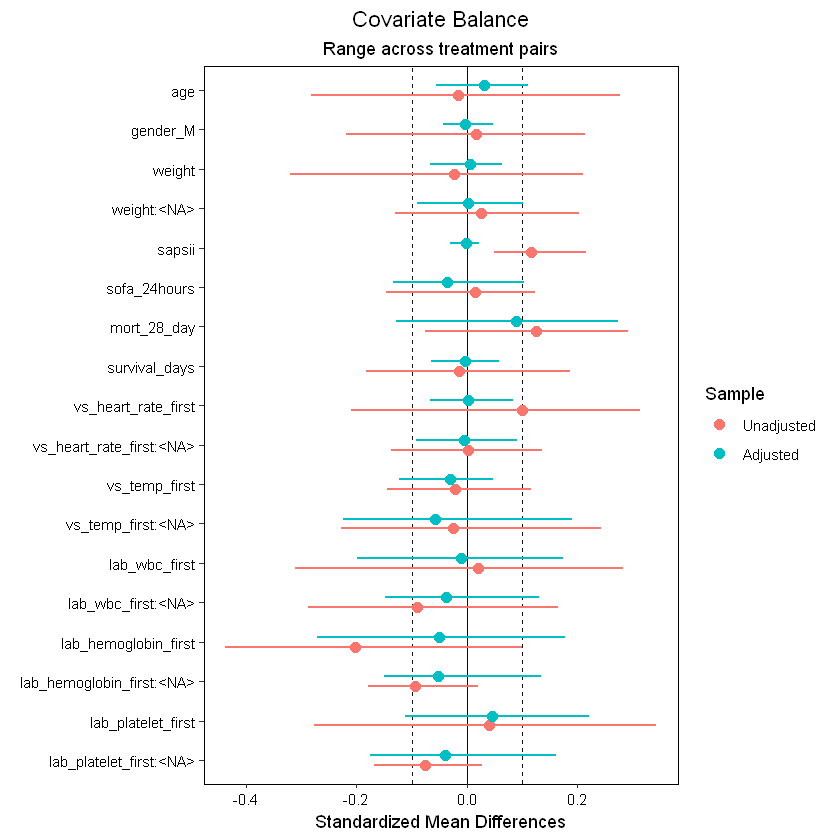

In [24]:
love.plot(Wtit,threshold=0.1,agg.fun="range",binary="std")

In [25]:
library(PSweight)

Warning message:
"package 'PSweight' was built under R version 4.3.3"


In [26]:
summary(full_data)


    stay_id            hadm_id           subject_id          gender         
 Min.   :30002548   Min.   :20002810   Min.   :10001217   Length:4401       
 1st Qu.:32431171   1st Qu.:22479831   1st Qu.:12613157   Class :character  
 Median :34987065   Median :24912349   Median :15063388   Mode  :character  
 Mean   :34963598   Mean   :24989187   Mean   :15058878                     
 3rd Qu.:37443929   3rd Qu.:27547009   3rd Qu.:17528049                     
 Max.   :39999172   Max.   :29995505   Max.   :19999987                     
                                                                            
      age             sapsii         icu_intime                    
 Min.   : 18.16   Min.   :  2.00   Min.   :2110-01-12 00:54:00.00  
 1st Qu.: 54.30   1st Qu.: 27.00   1st Qu.:2134-10-22 07:41:31.00  
 Median : 64.51   Median : 35.00   Median :2154-09-25 13:12:24.00  
 Mean   : 64.11   Mean   : 36.85   Mean   :2154-10-26 14:18:01.78  
 3rd Qu.: 75.22   3rd Qu.: 44.00   3rd Qu.:2

In [27]:
library(tidyverse)



In [28]:

summary(full_data)

    stay_id            hadm_id           subject_id          gender         
 Min.   :30002548   Min.   :20002810   Min.   :10001217   Length:4401       
 1st Qu.:32431171   1st Qu.:22479831   1st Qu.:12613157   Class :character  
 Median :34987065   Median :24912349   Median :15063388   Mode  :character  
 Mean   :34963598   Mean   :24989187   Mean   :15058878                     
 3rd Qu.:37443929   3rd Qu.:27547009   3rd Qu.:17528049                     
 Max.   :39999172   Max.   :29995505   Max.   :19999987                     
                                                                            
      age             sapsii         icu_intime                    
 Min.   : 18.16   Min.   :  2.00   Min.   :2110-01-12 00:54:00.00  
 1st Qu.: 54.30   1st Qu.: 27.00   1st Qu.:2134-10-22 07:41:31.00  
 Median : 64.51   Median : 35.00   Median :2154-09-25 13:12:24.00  
 Mean   : 64.11   Mean   : 36.85   Mean   :2154-10-26 14:18:01.78  
 3rd Qu.: 75.22   3rd Qu.: 44.00   3rd Qu.:2

In [29]:
library(mice)

In [30]:
# 确定有缺失值的列
cols_with_na <- names(full_data)[colSums(is.na(full_data)) > 0]
print(cols_with_na)

 [1] "weight"                         "infection"                     
 [3] "vs_heart_rate_first"            "vs_heart_rate_min"             
 [5] "vs_heart_rate_max"              "vs_cvp_first"                  
 [7] "vs_cvp_min"                     "vs_cvp_max"                    
 [9] "vs_map_first"                   "vs_map_min"                    
[11] "vs_map_max"                     "vs_temp_first"                 
[13] "vs_temp_min"                    "vs_temp_max"                   
[15] "lab_hemoglobin_first"           "lab_hemoglobin_min"            
[17] "lab_hemoglobin_max"             "lab_hemoglobin_abnormal"       
[19] "lab_platelet_first"             "lab_platelet_min"              
[21] "lab_platelet_max"               "lab_platelet_abnormal"         
[23] "lab_creatinine_kinase_first"    "lab_creatinine_kinase_min"     
[25] "lab_creatinine_kinase_max"      "lab_creatinine_kinase_abnormal"
[27] "lab_wbc_first"                  "lab_wbc_min"                   
[29] "

In [31]:
# 使用平均值填充缺失值
full_data_imputed <- full_data
for (col in cols_with_na) {
  full_data_imputed[, col] <- ifelse(is.na(full_data[, col]),
                                    mean(full_data[, col], na.rm = TRUE),
                                    full_data[, col])
}

Warning message in mean.default(full_data[, col], na.rm = TRUE):
"argument is not numeric or logical: returning NA"


In [32]:
str(full_data$pre_dose_val_rx_group)

 chr [1:4401] "0" "Medium" "0" "0" "0" "0" "Medium" "0" "0" "0" "0" "0" "0" ...


In [33]:

PS.fmu <- pre_dose_val_rx_group ~ sapsii + sofa_24hours + 
          lab_wbc_first + lab_hemoglobin_first + lab_platelet_first

umSt<-SumStat(ps.formula=PS.fmu,data=full_data_imputed,weight=c("IPW","treated","overlap","matching","entropy"), method="glm") 




In [34]:
PS.fmu

pre_dose_val_rx_group ~ sapsii + sofa_24hours + lab_wbc_first + 
    lab_hemoglobin_first + lab_platelet_first

In [35]:
SumSt<-SumStat(ps.formula=PS.fmu,data=full_data_imputed,weight=c("IPW","treated","overlap","matching","entropy"), method="glm")

In [36]:
summary(SumSt) #结果中会显示加权前后各组的协变量均值和SMD

unweighted result
                      Mean 0 Mean High Mean Low Mean Medium   SMD
sapsii                36.608    37.352   38.155      39.881 0.049
sofa_24hours           3.682     3.981    3.543       3.914 0.100
lab_wbc_first         11.734     9.101   11.482      11.267 0.303
lab_hemoglobin_first  10.407     9.530    9.725       9.517 0.432
lab_platelet_first   202.608   167.827  211.114     198.305 0.273

IPW result
                      Mean 0 Mean High Mean Low Mean Medium   SMD
sapsii                36.834    34.837   36.750      36.114 0.133
sofa_24hours           3.682     3.451    3.660       3.492 0.078
lab_wbc_first         11.668    10.705   11.559      11.630 0.114
lab_hemoglobin_first  10.315    10.170   10.262      10.323 0.070
lab_platelet_first   202.708   211.896  202.827     212.712 0.074

treated result
                      Mean 0 Mean High Mean Low Mean Medium   SMD
sapsii                39.769    39.041   39.824      39.881 0.047
sofa_24hours           3.896  

In [37]:
tail(SumSt[["ps.weights"]])

,pre_dose_val_rx_group,zindex,IPW,treated,overlap,matching,entropy
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
4396,Low,3,0.0045134219,0.0024855936,0.0024547519,0.0022027797,0.0031724416
4397,0,1,0.0002558748,0.0002209842,0.0003063337,0.0003541359,0.0002505999
4398,0,1,0.0002452792,0.0001180627,0.0001614340,0.0001721739,0.0001714407
4399,Medium,4,0.0079428561,0.0066225166,0.0030025882,0.0021991348,0.0063818576
4400,0,1,0.0002691841,0.0003527844,0.0003645459,0.0003513964,0.0003299238
4401,Medium,4,0.0077843388,0.0066225166,0.0102326458,0.0132672075,0.0076261169


In [38]:
IPW<-SumSt[["ps.weights"]][,3] #IPW权重

In [39]:
SumSt[["ess"]] #有效样本量，effective sample sizes。有效样本量定义参照Am J Epidemiol. 2019;188(1): 250–257.

,unweighted,IPW,treated,overlap,matching,entropy
0,3868,3858.42121,3114.58813,3092.33763,2875.8370,3523.07526
High,54,43.25747,46.95605,52.99207,54.0000,46.79069
Low,328,295.94138,317.41806,294.69796,265.1955,323.73831
Medium,151,126.31949,151.00000,139.71744,128.7339,145.79908


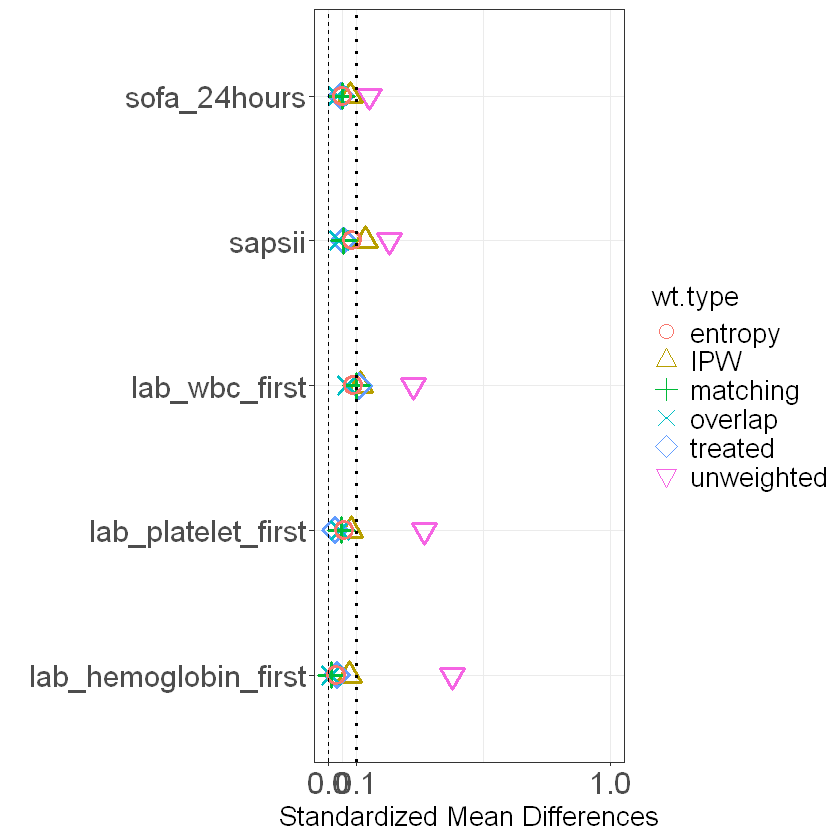

In [40]:
plot(SumSt,type="balance") #可绘制估算的倾向值的直方图（"hist")、估算的倾向值的密度图（"density"）、均衡统计量（"balance"）

In [41]:
library(tableone)
library(survey)
library(grid)
library(survival)

In [42]:
nmes<-full_data_imputed

In [43]:
Svy.design<-svydesign(ids=~1,weights=iptw,data=nmes) #指定调查设计的信息。ids=~1或~0表示没有标识集聚性（多水平）的变量。此处使用的是weighit函数生成的权重

In [44]:
Tabipw.stas<-svyCreateTableOne(vars=Sum.vars,strata="pre_dose_val_rx_group",data=Svy.design,test=TRUE,smd=TRUE,addOverall=TRUE) #本例在导入数据后已经将分类变量设置为了因子，此处无需再指定factorVars参数

In [45]:
Tab.ipw<-print(Tabipw.stas,catDigits=2,contDigits=2,pDigits=3,test=TRUE,smd=TRUE,noSpaces=TRUE)

                                  Stratified by pre_dose_val_rx_group
                                   Overall         0               
  n                                3423.83         1092.16         
  age (mean (SD))                  64.46 (14.92)   64.14 (15.15)   
  gender = M (%)                   1619.64 (47.30) 520.44 (47.65)  
  weight (mean (SD))               81.41 (21.03)   80.93 (22.06)   
  pre_dose_val_rx_group (%)                                        
     0                             1092.16 (31.90) 1092.16 (100.00)
     High                          703.17 (20.54)  0.00 (0.00)     
     Low                           893.07 (26.08)  0.00 (0.00)     
     Medium                        735.44 (21.48)  0.00 (0.00)     
  sapsii (mean (SD))               36.82 (13.88)   36.81 (13.86)   
  sofa_24hours (mean (SD))         3.57 (2.83)     3.70 (3.02)     
  mort_28_day (mean (SD))          0.10 (0.30)     0.10 (0.30)     
  survival_days (mean (SD))        244.58 (613

In [46]:
write.csv(Tab.ipw, file = "D:\\360MoveData\\Users\\yanghui\\Desktop\\tab2.csv",fileEncoding = "GBK", row.names = TRUE)

In [47]:
library(VGAM)

Warning message:
"package 'VGAM' was built under R version 4.3.3"
Loading required package: stats4

Loading required package: splines


Attaching package: 'VGAM'


The following objects are masked from 'package:mlogit':

    has.intercept, lrtest


The following object is masked from 'package:WeightIt':

    calibrate


The following objects are masked from 'package:rms':

    calibrate, lrtest


The following object is masked from 'package:VIM':

    wine


The following object is masked from 'package:survey':

    calibrate




In [48]:
# 安装和加载ordinal包

library(ordinal)


Warning message:
"package 'ordinal' was built under R version 4.3.3"

Attaching package: 'ordinal'


The following objects are masked from 'package:VGAM':

    dgumbel, dlgamma, pgumbel, plgamma, qgumbel, rgumbel, wine


The following object is masked from 'package:dfidx':

    slice


The following object is masked from 'package:mice':

    convergence


The following object is masked from 'package:VIM':

    wine


The following object is masked from 'package:dplyr':

    slice




In [49]:
full_data$pre_dose_val_rx_group <- factor(full_data$pre_dose_val_rx_group, ordered = TRUE)

In [50]:

# 使用clm()函数拟合有序多分类的logistic回归模型
logi <- clm(pre_dose_val_rx_group ~ mort_28_day+ sapsii + sofa_24hours +  lab_wbc_first + lab_hemoglobin_first + lab_platelet_first,
  data = full_data,
  weights = full_data$ps_weight)




In [51]:

# 查看模型结果
summary(logi)



formula: 
pre_dose_val_rx_group ~ mort_28_day + sapsii + sofa_24hours + lab_wbc_first + lab_hemoglobin_first + lab_platelet_first
data:    full_data

 link  threshold nobs     logLik   AIC     niter max.grad cond.H 
 logit flexible  3387.098 -4630.71 9279.42 4(0)  5.56e-07 8.0e+06

Coefficients:
                       Estimate Std. Error z value Pr(>|z|)    
mort_28_day           0.3967310  0.1131919   3.505 0.000457 ***
sapsii                0.0008762  0.0025184   0.348 0.727905    
sofa_24hours         -0.0368749  0.0136712  -2.697 0.006991 ** 
lab_wbc_first        -0.0052522  0.0038648  -1.359 0.174152    
lab_hemoglobin_first -0.0519525  0.0160548  -3.236 0.001212 ** 
lab_platelet_first    0.0003199  0.0002623   1.219 0.222753    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Threshold coefficients:
           Estimate Std. Error z value
0|High      -1.3505     0.2075  -6.507
High|Low    -0.4809     0.2065  -2.329
Low|Medium   0.7103     0.2075   3.423
(71 obs

In [52]:
# 数据准备
model_results <- data.frame(
  Variable = c("mort_28_day1", "sapsii", "sofa_24hours", "lab_wbc_first", "lab_hemoglobin_first", "lab_platelet_first"),
  Estimate = c(0.3967310, 0.0008762, -0.0368749, -0.0052522, -0.0519525, 0.0003199),
  Std.Error = c(0.1131919, 0.0025184, 0.0136712, 0.0038648, 0.0160548, 0.0002623),
  z_value = c(3.505, 0.348, -2.697, -1.359, -3.236, 1.219),
  p_value = c(0.000457, 0.727905, 0.006991, 0.174152, 0.001212, 0.222753)
)

# 计算OR及其95%CI
model_results <- model_results %>%
  mutate(OR = exp(Estimate),
         Lower_CI = exp(Estimate - 1.96 * Std.Error),
         Upper_CI = exp(Estimate + 1.96 * Std.Error),
         Signif_Codes = ifelse(p_value < 0.001, "***",
                              ifelse(p_value < 0.01, "**",
                                     ifelse(p_value < 0.05, "*", ""))))

# 查看结果
print(model_results)

              Variable   Estimate Std.Error z_value  p_value        OR
1         mort_28_day1  0.3967310 0.1131919   3.505 0.000457 1.4869559
2               sapsii  0.0008762 0.0025184   0.348 0.727905 1.0008766
3         sofa_24hours -0.0368749 0.0136712  -2.697 0.006991 0.9637967
4        lab_wbc_first -0.0052522 0.0038648  -1.359 0.174152 0.9947616
5 lab_hemoglobin_first -0.0519525 0.0160548  -3.236 0.001212 0.9493740
6   lab_platelet_first  0.0003199 0.0002623   1.219 0.222753 1.0003200
   Lower_CI  Upper_CI Signif_Codes
1 1.1910972 1.8563035          ***
2 0.9959484 1.0058292             
3 0.9383142 0.9899713           **
4 0.9872547 1.0023255             
5 0.9199648 0.9797233           **
6 0.9998058 1.0008344             


In [54]:
write.csv(model_results, file = "D:\\360MoveData\\Users\\yanghui\\Desktop\\model_results.csv",fileEncoding = "GBK", row.names = TRUE)

mort_28_day1变量的OR为1.4871,表示28天死亡风险每增加1单位,死亡风险增加约49%。
sapsii变量的OR为1.0009,表示SAPS II每增加1单位,死亡风险增加约0.09%。
sofa_24hours变量的OR为0.9639,表示SOFA评分每增加1单位,死亡风险降低约3.61%。
lab_wbc_first变量的OR为0.9948,表示白细胞计数每增加1单位,死亡风险降低约0.52%。
lab_hemoglobin_first变量的OR为0.9494,表示血红蛋白每增加1单位,死亡风险降低约5.06%。
lab_platelet_first变量的OR为1.0003,表示血小板计数每增加1单位,死亡风险增加约0.03%。

In [53]:


# 阈值系数
threshold_coef <- data.frame(
  Threshold = c("0|High", "High|Low", "Low|Medium"),
  Estimate = c(-1.3505, -0.4809, 0.7103),
  Std.Error = c(0.2075, 0.2065, 0.2075)
)

# 计算比值比及置信区间
threshold <-(threshold_coef %>%
  mutate(OR = exp(Estimate),
         Lower_CI = exp(Estimate - 1.96 * Std.Error),
         Upper_CI = exp(Estimate + 1.96 * Std.Error)) %>%
  select(Threshold, OR, Lower_CI, Upper_CI))

print(threshold)

   Threshold        OR  Lower_CI  Upper_CI
1     0|High 0.2591107 0.1725273 0.3891463
2   High|Low 0.6182267 0.4124501 0.9266679
3 Low|Medium 2.0346015 1.3547271 3.0556734


In [55]:
write.csv(threshold, file = "D:\\360MoveData\\Users\\yanghui\\Desktop\\threshold.csv",fileEncoding = "GBK", row.names = TRUE)